# Predicting NASDAQ indexes during the COVID-19 pandemic

## In the past 5 years

 ### Data preprocessing

In [2]:
### Data loading in Colab
!rm -rf ./ada-2020-project-milestone-p3-p3_adenosine-deaminase/
!git clone https://github.com/epfl-ada/ada-2020-project-milestone-p3-p3_adenosine-deaminase.git

Cloning into 'ada-2020-project-milestone-p3-p3_adenosine-deaminase'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 79 (delta 21), reused 66 (delta 15), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [ ]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4
import os    
os.environ['THEANO_FLAGS'] = 'device=cuda*'    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import pymc3 as pm
import arviz
import theano
import theano.tensor as tt

In [4]:
### Data directory configs

DATA_DIR = './ada-2020-project-milestone-p3-p3_adenosine-deaminase/data_yida/'
DATA_2020_DIR = 'ada-2020-project-milestone-p3-p3_adenosine-deaminase/additional_data/'

In [5]:
df_healthcare = pd.read_csv(DATA_DIR + 'IXHC.csv')
df_biotech = pd.read_csv(DATA_DIR + 'NBI.csv')
df_healthcare.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
257,2020-11-02,1023.380005,1100.969971,1003.500000,1087.619995,1087.619995,5046800
258,2020-11-09,1099.530029,1106.780029,1065.349976,1104.359985,1104.359985,6324500
259,2020-11-16,1111.469971,1111.489990,1078.869995,1091.459961,1091.459961,5446500
260,2020-11-23,1098.770020,1123.569946,1088.209961,1123.569946,1123.569946,3373000
261,2020-11-30,1132.060059,1135.439941,1116.579956,1135.010010,1135.010010,3571800


Our datasets include stock indexes from 2015/12/01 to 2020/12/01.

The names of columns are quite staightforward. Here we take **NASDAQ HealthCare** as an example:
+ Date: the first day of every week.
+ Open: the opening price in each week.
+ High: the highest price in each week.
+ Low: the lowest price in each week.
+ Close: the closing price in each week. To be more specific, closing prices on every Friday.

It's noted that **Date** is the first day of the weekly summary rather than the last day and that is the first issue. Besides, as we can observe, 2020-11-30 is the first day of the week so the last row of **NASDAQ HealthCare** dataframe is just the summary of prices for two days (2020-11-30 and 2020/12/01). It's safe to drop it.

In [6]:
df_healthcare['Date'] = pd.to_datetime(df_healthcare['Date'])
df_healthcare['Date'] = df_healthcare['Date'] + pd.Timedelta('6d')
df_healthcare.set_index('Date', inplace=True)
df_healthcare = df_healthcare[0:-1]

Now the **NASDAQ HealthCare** dateset is exactly what we want:

In [7]:
df_healthcare.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-01,1059.619995,1067.189941,1003.510010,1013.820007,1013.820007,4118400
2020-11-08,1023.380005,1100.969971,1003.500000,1087.619995,1087.619995,5046800
2020-11-15,1099.530029,1106.780029,1065.349976,1104.359985,1104.359985,6324500
2020-11-22,1111.469971,1111.489990,1078.869995,1091.459961,1091.459961,5446500
2020-11-29,1098.770020,1123.569946,1088.209961,1123.569946,1123.569946,3373000


We do the same process again for **NASDAQ Biotechnology** dataset:

In [8]:
df_biotech['Date'] = pd.to_datetime(df_biotech['Date'])
df_biotech['Date'] = df_biotech['Date'] + pd.Timedelta('6d')
df_biotech.set_index('Date', inplace=True)
df_biotech = df_biotech[0:-1]
df_biotech.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-01,4252.459961,4286.129883,4054.510010,4097.970215,4097.970215,1099300
2020-11-08,4125.450195,4469.339844,4033.139893,4355.970215,4355.970215,1197000
2020-11-15,4374.060059,4446.140137,4277.850098,4436.250000,4436.250000,1014200
2020-11-22,4466.890137,4466.890137,4318.939941,4364.149902,4364.149902,1243900
2020-11-29,4395.709961,4505.310059,4342.129883,4505.310059,4505.310059,595300


Here, We process Google Trends data (also from 2015/12/01 to 2020/12/01) about topic "Vaccine". The tail of the result dataframe matches the previous NASDAQ data.

In [9]:
df_trends = pd.read_csv(DATA_DIR + 'trends_data.csv')
df_trends.drop(labels=['Week'], axis=0, inplace=True)
df_trends.index = pd.to_datetime(df_trends.index)
df_trends.index.set_names('Date', inplace=True)
df_trends.rename(columns={'Category: All categories': 'Vaccine'}, inplace=True)
df_trends['Vaccine'] = df_trends['Vaccine'].apply(lambda x: int(x))

In [10]:
df_trends.tail()

,Vaccine
Date,
2020-11-01,27
2020-11-08,85
2020-11-15,84
2020-11-22,70
2020-11-29,100


After the individual processing, all three datesets share the same time index and can be merged perfectly. We first experiment with the closing prices of both stocks.

In [11]:
data = pd.DataFrame({'healthcare': df_healthcare['Close'], 
            'biotech': df_biotech['Close'], 'vaccine': df_trends['Vaccine']})
data.head(5)

,healthcare,biotech,vaccine
Date,,,
2015-12-06,743.700012,3470.639893,12
2015-12-13,718.440002,3347.600098,12
2015-12-20,735.000000,3449.010010,9
2015-12-27,757.659973,3555.060059,9
2016-01-03,752.390015,3540.439941,12


Let's take a look at the trends for both.

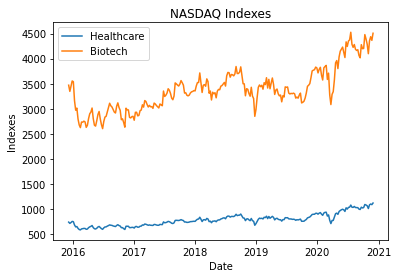

In [12]:
plt.plot(data['healthcare'], label='Healthcare')
plt.plot(data['biotech'], label='Biotech')
plt.title('NASDAQ Indexes')
plt.xlabel('Date')
plt.ylabel('Indexes')
plt.legend()

It seems that **NASDAQ Healthcare** is much richer than the other one while facing wilder swings. 

To get a better grasp of how the both stocks fluctuate, let's compare another plot that uses standardized data.

In [13]:
def standardization(data):
    return (data-data.min())/(data.max()-data.min())

data['healthcare_std'] = standardization(data['healthcare'])
data['biotech_std'] = standardization(data['biotech'])

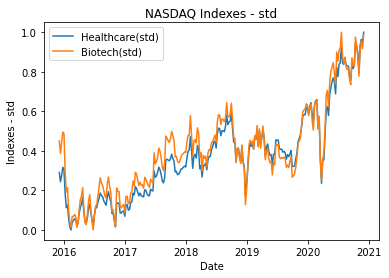

In [14]:
plt.plot(data['healthcare_std'], label='Healthcare(std)')
plt.plot(data['biotech_std'], label='Biotech(std)')
plt.title("NASDAQ Indexes - std")
plt.xlabel('Date')
plt.ylabel('Indexes - std')
plt.legend()

Now the both trends over the past 5 years become more identical, and they seem to be in the same boat, rising and falling together.

In [15]:
import scipy.stats as stats
stats.pearsonr(data['healthcare'], data['biotech'])

(0.9809738087744029, 2.113537455997617e-186)

### Build the models

The baseline model can be concluded by the formula:

$$y_{t}^{health} \sim y_{t-1}^{health} + y_{t-4}^{health} + e$$

$y_t$: Closing price of NASDAQ Healthcare at time $t$.

$y_{t-4}$: Closing price of NASDAQ Healthcare at time $t-4$.

We now extract the features accordingly. Because there are no features available for the first 4 rows, so they need to be dropped.

In [16]:
# merge all stock data 
data['healthcare.l1'] = data['healthcare'].shift(1)
data['biotech.l1'] = data['biotech'].shift(1)
data['healthcare.l4'] = data['healthcare'].shift(4)
data['biotech.l4'] = data['biotech'].shift(4)
data['vaccine.l1'] = data['vaccine'].shift(1)
data['vaccine.l4'] = data['vaccine'].shift(4)
data.dropna(inplace=True)
data.head()

,healthcare,biotech,vaccine,healthcare_std,biotech_std,healthcare.l1,biotech.l1,healthcare.l4,biotech.l4,vaccine.l1,vaccine.l4
Date,,,,,,,,,,,
2016-01-03,752.390015,3540.439941,12,0.306789,0.487119,757.659973,3555.060059,743.700012,3470.639893,9.0,12.0
2016-01-10,685.900024,3160.219971,12,0.182613,0.289124,752.390015,3540.439941,718.440002,3347.600098,12.0,12.0
2016-01-17,648.380005,2972.570068,12,0.112541,0.191408,685.900024,3160.219971,735.000000,3449.010010,12.0,9.0
2016-01-24,655.340027,3013.870117,13,0.125539,0.212914,648.380005,2972.570068,757.659973,3555.060059,12.0,9.0
2016-01-31,618.659973,2796.469971,13,0.057036,0.099706,655.340027,3013.870117,752.390015,3540.439941,13.0,12.0


In [17]:
# Simple linear model using data healthcare(t-1) and healthcare(t-4)
X = data[['healthcare.l1', 'healthcare.l4']]
X = sm.add_constant(X)
y = data['healthcare']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2688.
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          1.27e-171
Time:                        20:37:43   Log-Likelihood:                -1202.1
No. Observations:                 257   AIC:                             2410.
Df Residuals:                     254   BIC:                             2421.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.0211     11.180      0.449

Old people always say that the stock market is unpredictable. We have learned the same lesson from the paper that we were asked to replicate. 

> As Nelson and Plosser (1982) and many subsequent authors have pointed out, it is very common for macroeconomic data to be represented as a random walk. For a random walk, the best univariate forecast for $y_t$ is simply $yt_1$. 

Let's see if we can gain slightly better $R^2$ by replacing $y_{t-4}^{health}$ with another feature.

In [18]:
# Do the same thing with two stock indicators
X = data[['healthcare.l1', 'biotech.l1']]
X = sm.add_constant(X)
y = data['healthcare']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2738.
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          1.34e-172
Time:                        20:37:43   Log-Likelihood:                -1199.8
No. Observations:                 257   AIC:                             2406.
Df Residuals:                     254   BIC:                             2416.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            38.2208     16.556      2.309

In [19]:
# Add google trends vaccine
X = data[['healthcare.l1', 'vaccine.l1']]
X = sm.add_constant(X)
y = data['healthcare']
model = sm.OLS(y, X).fit()
print(model.summary())  

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2687.
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          1.32e-171
Time:                        20:37:43   Log-Likelihood:                -1202.2
No. Observations:                 257   AIC:                             2410.
Df Residuals:                     254   BIC:                             2421.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            15.2324     12.865      1.184

We have tried NASDAQ Biotechnology index, Google Trends on "Vaccine", and both of the new features. A surprising find is that, in the long run (in our case, 5 years), only NASDAQ Biotechnology index brings tiny improvement to the models with convincing p-value. However, Google Trends is likely to make no contribution to the models.

## A different direction: COVID-19 

It's time to scale our scope to this extraordinary year. One of the most significant event has changed the lives of countless millions of people. COVID-19 is still rife and must have caused unfathomable imfluence over the global economics. 

There is no doubt that the most iconic data about COVID-19 is the number of new cases for each day in each area. In order to explore the changes of stock market as far as possible, we utilize the COVID-19 data that comes from the European Union and focus on the new cases in USA.

In [20]:
# df_us_covid contains number of new cases and new deaths in USA
df_cases = pd.read_csv(DATA_DIR + 'covid.csv')
df_us_covid = df_cases[df_cases['location'] == 'United States'] 
df_us_covid.set_index('date', inplace=True)
df_us_covid.fillna(0, inplace=True)
df_us_covid.index = pd.to_datetime(df_us_covid.index)
df_us_covid = df_us_covid[pd.Timestamp('2020-1-1'):pd.Timestamp('2020-12-1')][['new_cases', 'new_deaths']]
df_us_covid.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,new_cases,new_deaths
date,,
2020-01-22,0.0,0.0
2020-01-23,0.0,0.0
2020-01-24,1.0,0.0
2020-01-25,0.0,0.0
2020-01-26,3.0,0.0


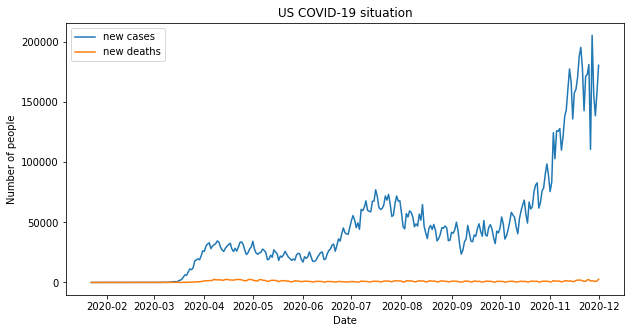

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(df_us_covid['new_cases'], label='new cases')
plt.plot(df_us_covid['new_deaths'], label='new deaths')
plt.title('US COVID-19 situation')
plt.xlabel('Date')
plt.ylabel('Number of people')
plt.legend()

In [22]:
# Because number of new cases are too large, we take logorithm of two variables
df_us_covid['new_cases.log'] = df_us_covid['new_cases'].apply(lambda x: 0 if x == 0 else np.log(x))
df_us_covid['new_deaths.log'] = df_us_covid['new_deaths'].apply(lambda x: 0 if x == 0 else np.log(x))

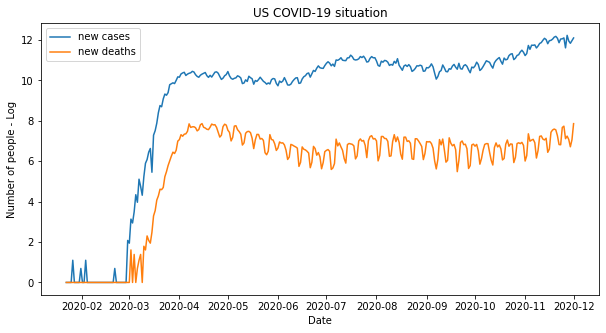

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(df_us_covid['new_cases.log'], label='new cases')
plt.plot(df_us_covid['new_deaths.log'], label='new deaths')
plt.title('US COVID-19 situation')
plt.xlabel('Date')
plt.ylabel('Number of people - Log')
plt.legend()

In [24]:
# df_ns contains complete data of NASDAQ Composite
df_ns = pd.read_csv(DATA_2020_DIR + '^IXIC.csv')
df_ns['Date'] = pd.to_datetime(df_ns['Date'])
df_ns.set_index('Date', inplace=True)

df_ns = df_ns.reindex(pd.date_range(start=pd.Timestamp('2020-1-1'), end=pd.Timestamp('2020-12-1'), freq='1D'))
df_ns.iloc[0] = df_ns.iloc[1]
df_ns.interpolate(method='linear', inplace=True)    
df_ns.head()

,Open,High,Low,Close,Adj Close,Volume
2020-01-01,9039.459961,9093.429688,9010.889648,9092.190430,9092.190430,2.848370e+09
2020-01-02,9039.459961,9093.429688,9010.889648,9092.190430,9092.190430,2.848370e+09
2020-01-03,8976.429688,9065.759766,8976.429688,9020.769531,9020.769531,2.567400e+09
2020-01-04,8965.453125,9067.976563,8965.453125,9037.669596,9037.669596,2.640973e+09
2020-01-05,8954.476563,9070.193359,8954.476563,9054.569662,9054.569662,2.714547e+09


In [25]:
# df_gt contains all the specific google trends we think may help with the prediction
df_gt = pd.read_csv(DATA_2020_DIR + 'google_trends.csv')
df_gt['date'] = pd.to_datetime(df_gt['date'])
df_gt.set_index('date', inplace=True)
df_gt.drop(['Unnamed: 0'], axis=1, inplace=True)
df_gt = df_gt[pd.Timestamp('2020-1-1'):pd.Timestamp('2020-12-1')]
df_gt.tail()

,vaccine_world,vaccine_US,unemployment_world,unemployment_US,trump_world,trump_US,lockdown_world,lockdown_US,loan_world,loan_US,italy_world,italy_US,election_world,election_US,covid_world,covid_US,china_world,china_US
date,,,,,,,,,,,,,,,,,,
2020-11-27,36.0,42.0,17.36,14.422222,8.0,16.0,12.923077,2.516129,60.2250,33.354839,13.575758,12.579710,0.5,0.5,43.0,45.617647,27.0,24.5
2020-11-28,39.0,47.0,14.26,12.455556,7.0,14.0,12.000000,4.645161,55.6625,33.354839,15.515152,14.405797,0.5,1.0,44.0,48.529412,27.6,26.0
2020-11-29,41.0,49.0,26.04,27.533333,7.0,13.0,11.076923,4.064516,52.9250,31.225806,15.515152,14.000000,0.5,0.5,43.0,49.500000,27.6,25.5
2020-11-30,48.0,61.0,31.62,30.155556,6.0,12.0,14.769231,4.064516,70.2625,42.580645,14.303030,12.782609,0.5,0.5,47.0,55.323529,28.8,28.0
2020-12-01,50.0,68.0,27.90,24.911111,6.0,12.0,13.846154,3.870968,72.0875,46.838710,13.818182,12.782609,0.5,0.5,47.0,55.323529,29.4,31.5


In [26]:
# data_2020 includes data_gt and close price one day before as features
data_2020 = df_gt.copy()
data_2020['close'] = df_ns['Close']
data_2020[['new_cases.log', 'new_deaths.log']] = df_us_covid[['new_cases.log', 'new_deaths.log']]
data_2020.fillna(0, inplace=True)

data_2020[['close.l1', 'new_cases.log', 'new_deaths.log']] = data_2020[['close', 'new_cases.log', 'new_deaths.log']].shift(1)
for feature in df_gt.columns:
    data_2020[feature] = data_2020[feature].shift(1)

data_2020 = data_2020.dropna()
data_2020.head()

,vaccine_world,vaccine_US,unemployment_world,unemployment_US,trump_world,trump_US,lockdown_world,lockdown_US,loan_world,loan_US,italy_world,italy_US,election_world,election_US,covid_world,covid_US,china_world,china_US,close,new_cases.log,new_deaths.log,close.l1
date,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.000000,0.0,6.0,2.0,3.913043,6.835443,0.5,0.5,52.0,26.0,15.0,17.0,0.205882,0.181818,0.477778,0.5,27.0,29.0,9092.190430,0.0,0.0,9092.190430
2020-01-03,0.000000,0.0,10.0,4.0,3.521739,6.075949,0.5,0.5,74.0,45.0,15.0,16.0,0.264706,0.363636,0.477778,0.5,26.0,25.0,9020.769531,0.0,0.0,9092.190430
2020-01-04,0.384615,0.0,9.0,4.0,12.521739,16.708861,0.5,0.5,72.0,47.0,14.0,15.0,0.411765,0.363636,0.477778,0.5,27.0,28.0,9037.669596,0.0,0.0,9020.769531
2020-01-05,0.000000,0.0,6.0,2.0,10.369565,15.189873,0.5,0.5,63.0,37.0,15.0,17.0,0.294118,0.318182,0.477778,0.5,27.0,28.0,9054.569662,0.0,0.0,9037.669596
2020-01-06,0.000000,0.0,8.0,5.0,10.369565,14.430380,0.5,0.5,61.0,33.0,16.0,18.0,0.411765,0.363636,0.477778,0.5,27.0,27.0,9071.469727,0.0,0.0,9054.569662


After preprocessing, we get the relevant data for each week:

Now integrate and filter the data in 2020.

Another round of traing using data in 2020.

In [27]:
# let's experiment with base model with only one variable namely close_l1
label = 'close'
base_features = ['close.l1']

base_X = data_2020[base_features]
base_X = sm.add_constant(base_X)
base_y = data_2020[label]
base_model = sm.OLS(base_y, base_X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 2.539e+04
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          2.10e-316
Time:                        20:37:44   Log-Likelihood:                -2155.8
No. Observations:                 335   AIC:                             4316.
Df Residuals:                     333   BIC:                             4323.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.0091     62.961      0.524      0.6

In [28]:
# Add two cases as features
covid_features = ['close.l1', 'new_cases.log', 'new_deaths.log']

covid_X = data_2020[covid_features]
covid_X = sm.add_constant(covid_X)
covid_y = data_2020[label]
covid_model = sm.OLS(covid_y, covid_X).fit()
print(covid_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     8554.
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          3.43e-313
Time:                        20:37:44   Log-Likelihood:                -2153.0
No. Observations:                 335   AIC:                             4314.
Df Residuals:                     331   BIC:                             4329.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             35.9230     64.633      0.

In [29]:
# Add one google trends each time to see the effect
print(f'google trends            coef         p-value')
print(f'================================================')
for feature in data_2020.columns[0:len(df_gt.columns)]:
    features = ['close.l1', feature]
    X = data_2020[features]
    X = sm.add_constant(X)
    y = data_2020[label]
    model = sm.OLS(y, X).fit()
    print(f'{feature:20}   {model.params[feature]:10f}  {model.pvalues[feature]:10f}')

google trends            coef         p-value
vaccine_world            0.846546    0.120363
vaccine_US               0.234911    0.706978
unemployment_world       0.824953    0.042066
unemployment_US          0.750846    0.047501
trump_world              1.605104    0.072550
trump_US                 1.444274    0.041564
lockdown_world           1.477151    0.005298
lockdown_US              1.481149    0.132070
loan_world               0.683976    0.471868
loan_US                  1.178303    0.180012
italy_world             -1.200994    0.143381
italy_US                -1.249507    0.092010
election_world           1.029566    0.294740
election_US              1.089156    0.286975
covid_world              0.780086    0.031134
covid_US                 0.684776    0.037480
china_world             -0.328304    0.720592
china_US                -1.096129    0.229030


In [30]:
# add all google trends
total_features = df_gt.columns.to_list()
total_features.append('close.l1')

X = data_2020[total_features]
X = sm.add_constant(X)
y = data_2020[label]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1417.
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          4.25e-292
Time:                        20:37:44   Log-Likelihood:                -2136.9
No. Observations:                 335   AIC:                             4314.
Df Residuals:                     315   BIC:                             4390.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                578.3019    219

In [31]:
df_params = pd.DataFrame(model.params[1:], columns=['coef'])
df_params['ratio'] = abs(df_params['coef'])/abs(df_params['coef']).sum() * 100

<BarContainer object of 19 artists>

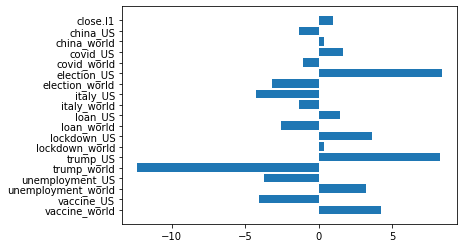

In [32]:
plt.barh(y=df_params.index, width=df_params['coef'])

([<matplotlib.patches.Wedge at 0x7f16211810f0>,
 [Text(1.078272854747086, 0.2175491914845233, 'vaccine_world'),
  Text(0.9142387109268283, 0.6116923895577349, 'vaccine_US'),
  Text(0.6551196643804644, 0.8836391940956602, 'unemployment_world'),
  Text(0.3336258427807277, 1.0481859553671045, 'unemployment_US'),
  Text(-0.48301395656777313, 0.988280080625298, 'trump_world'),
  Text(-1.088974385395347, 0.1553537510098365, 'trump_US'),
  Text(-1.0620142772931511, -0.286575775015102, 'lockdown_world'),
  Text(-0.9895928691036263, -0.48031859574583774, 'lockdown_US'),
  Text(-0.8071111119612393, -0.7473765135115579, 'loan_world'),
  Text(-0.6524648412070772, -0.8856012821742208, 'loan_US'),
  Text(-0.530117539380784, -0.9638336964647289, 'italy_world'),
  Text(-0.25629618950349403, -1.069725321400774, 'italy_US'),
  Text(0.13048327526678635, -1.0922335441084257, 'election_world'),
  Text(0.6804570334817688, -0.8642790206786181, 'election_US'),
  Text(0.9867655910485312, -0.4861004714281224, '

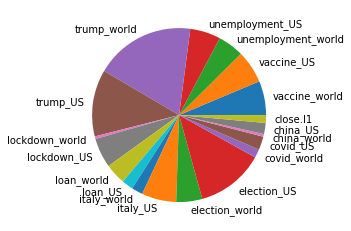

In [33]:
plt.pie(df_params['ratio'], labels=df_params.index)

In [34]:
start_date = pd.Timestamp('2020-2-1')
start_index = data_2020.index.tolist().index(start_date)

base = [-1.0] * start_index
cases = [-1.0] * start_index
deaths = [-1.0] * start_index

### Traing for out-sample forecasting. Here we use sklearn library. 
out_base_model = LinearRegression()
out_cases_model = LinearRegression()
out_deaths_model = LinearRegression()

cases_features = ['close.l1', 'new_cases.log']
deaths_features = ['close.l1', 'new_deaths.log']

In [35]:
# As the rolling window become broader, more data can be used for trainig. 
for i in range(start_index, len(data_2020)):
    # Base model traing and predicting.
    out_base_model.fit(data_2020[:i][base_features], data_2020[:i][label])
    base_pred = out_base_model.predict([data_2020.iloc[i][base_features]])
    base.append(base_pred[0])
    
    out_cases_model.fit(data_2020[:i][cases_features], data_2020[:i][label])
    cases_pred = out_cases_model.predict([data_2020.iloc[i][cases_features]])
    cases.append(cases_pred[0])
    
    out_deaths_model.fit(data_2020[:i][deaths_features], data_2020[:i][label])
    deaths_pred = out_deaths_model.predict([data_2020.iloc[i][deaths_features]])
    deaths.append(deaths_pred[0])

In [36]:
data_2020['base'] = base
data_2020['cases'] = cases
data_2020['deaths'] = deaths

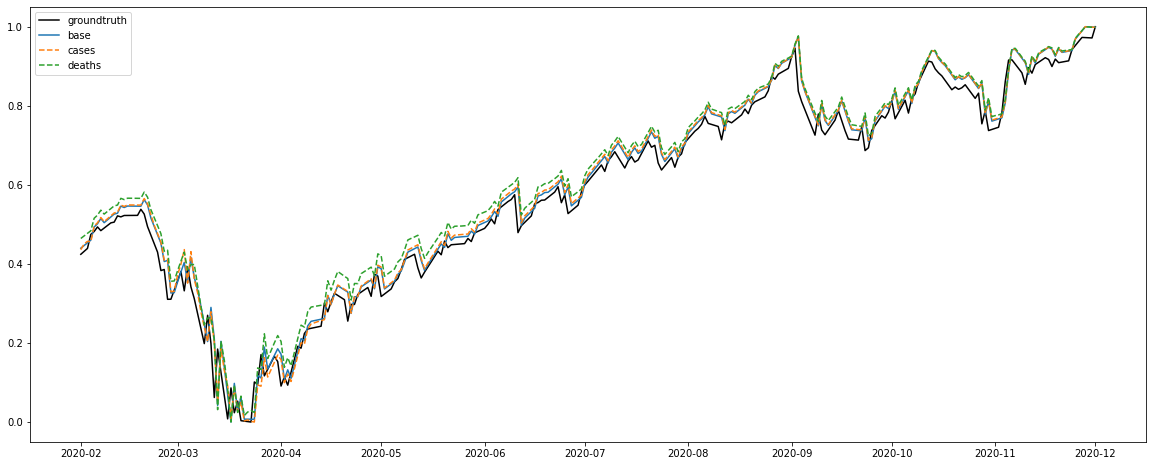

In [37]:
plt.figure(figsize=(20, 8))
plt.plot(standardization(data_2020[start_date:]['close']), 'k', label='groundtruth')
plt.plot(standardization(data_2020[start_date:]['base']), label='base')
plt.plot(standardization(data_2020[start_date:]['cases']), '--', label='cases')
plt.plot(standardization(data_2020[start_date:]['deaths']), '--', label='deaths')
# plt.plot(data_2020[start_date:]['close'], label='groundtruth')
# plt.plot(data_2020[start_date:]['base'], label='base')
# plt.plot(data_2020[start_date:]['cases'], '--', label='cases')
# plt.plot(data_2020[start_date:]['deaths'], '--', label='deaths')
plt.legend()

In [38]:
# MAE of three model: death cases improves a lot
result = data_2020[start_date:]
base_mae = sum(abs(result['base'] - result[label]))/len(result[label])
cases_mae = sum(abs(result['cases'] - result[label]))/len(result[label])
deaths_mae = sum(abs(result['deaths'] - result[label]))/len(result[label])
print(base_mae)
print(cases_mae)
print(deaths_mae)

111.86161143073446
111.3620282294857
106.33130006703873


In [39]:
df_results = data_2020[['close', 'base', 'cases', 'deaths']].copy()

for feature in data_2020.columns[0:len(df_gt.columns)]:
    trends = [-1.0] * start_index
    trends_features = ['close.l1', feature]
    out_trends_model = LinearRegression()
    for i in range(start_index, len(data_2020)):
        # Trends model training and predicting.
        out_trends_model.fit(data_2020[:i][trends_features], data_2020[:i][label])
        trends_pred = out_trends_model.predict([data_2020.iloc[i][trends_features]])
        trends.append(trends_pred[0])
    df_results[feature] = trends

In [40]:
# Calculate MAE for adding each google trends
result = df_results[start_date:]
print(f'feature                MAE')
print('=================================')
for i in result.columns:
    mae = sum(abs(result[i] - result[label]))/len(result[label])
    print(f'{i:20} {mae:10f}')

feature                MAE
close                  0.000000
base                 111.861611
cases                111.362028
deaths               106.331300
vaccine_world        111.744920
vaccine_US           116.618413
unemployment_world   111.927515
unemployment_US      112.396836
trump_world          111.951980
trump_US             112.255973
lockdown_world       114.344501
lockdown_US          115.509797
loan_world           112.436685
loan_US              111.698660
italy_world          116.318567
italy_US             115.139538
election_world       125.238454
election_US          119.769683
covid_world          108.633433
covid_US             110.582560
china_world          112.592957
china_US             112.674001


In [42]:
# define turning points
turning_points = [[pd.Timestamp('2020-02-10'), pd.Timestamp('2020-02-25')],
                  [pd.Timestamp('2020-03-10'), pd.Timestamp('2020-03-30')],
                  [pd.Timestamp('2020-08-20'), pd.Timestamp('2020-09-15')],
                  [pd.Timestamp('2020-10-10'), pd.Timestamp('2020-11-10')]]

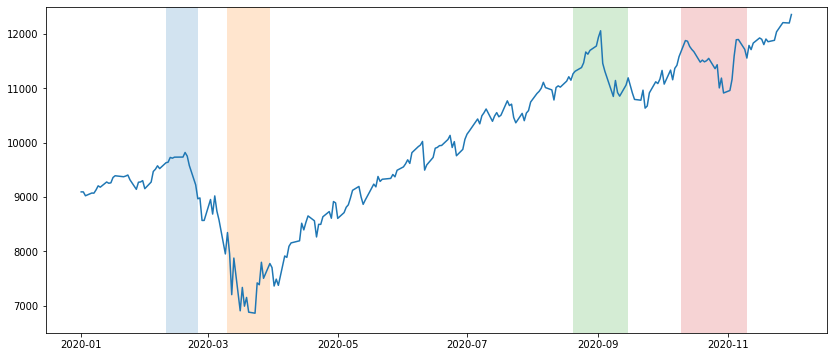

In [43]:
plt.figure(figsize=(14, 6))
y_min, y_max = 6500, 12500
plt.ylim([y_min, y_max])

plt.plot(df_ns['Close'])
for point_i in turning_points:
    plt.fill_betweenx([y_min, y_max], point_i[0], point_i[1], alpha=0.2)

In [44]:
# calculate MAE for four turning points
df_turnings = pd.DataFrame(df_gt.columns.to_list(), columns=['Features'])

base_turning_maes = []
cases_turning_maes = []
deaths_turning_maes = []
for i in range(len(turning_points)):
    data_period = df_results[turning_points[i][0]:turning_points[i][1]]
    mae = sum(abs(data_period['base'] - data_period[label]))/len(data_period)
    base_turning_maes.append(mae)
    mae = sum(abs(data_period['cases'] - data_period[label]))/len(data_period)
    cases_turning_maes.append(mae)
    mae = sum(abs(data_period['deaths'] - data_period[label]))/len(data_period)
    deaths_turning_maes.append(mae)
    
print(base_turning_maes)
print(cases_turning_maes)
print(deaths_turning_maes)

[73.10888791968773, 307.13146561164604, 113.64825468897187, 103.55070906773523]
[75.18790768374754, 321.09822112384256, 111.23447154785741, 103.29042538861563]
[73.10888791968773, 312.3182862058438, 111.43753593457149, 103.0212412949844]


In [45]:
# Do the same thing for each google trends
for i in range(len(turning_points)):
    data_period = df_results[turning_points[i][0]:turning_points[i][1]]
    mae_col = f'Period_{i+1}'
    improvement_col = f'{mae_col}_ratio'
    maes = []
    for trend in df_turnings['Features']:
        mae = sum(abs(data_period[trend] - data_period[label]))/len(data_period)
        maes.append(mae)
    df_turnings[mae_col] = maes
    df_turnings[improvement_col] = -(df_turnings[mae_col] - base_turning_maes[i])/base_turning_maes[i]

In [46]:
df_turnings

,Features,Period_1,Period_1_ratio,Period_2,Period_2_ratio,Period_3,Period_3_ratio,Period_4,Period_4_ratio
0,vaccine_world,72.801791,0.004201,307.749603,-0.002013,113.301656,0.003050,106.069103,-0.024320
1,vaccine_US,72.127055,0.013430,293.091340,0.045714,113.731134,-0.000729,103.375827,0.001689
2,unemployment_world,70.843047,0.030993,335.868552,-0.093566,110.175424,0.030558,103.708718,-0.001526
3,unemployment_US,70.721880,0.032650,337.974421,-0.100423,110.926453,0.023949,103.881593,-0.003195
4,trump_world,73.688757,-0.007932,314.647118,-0.024470,113.280068,0.003240,114.660231,-0.107286
5,trump_US,72.161093,0.012964,321.572181,-0.047018,113.609109,0.000344,112.330720,-0.084789
6,lockdown_world,73.436381,-0.004480,391.318120,-0.274106,108.369640,0.046447,110.060532,-0.062866
7,lockdown_US,72.760097,0.004771,384.684561,-0.252508,108.414815,0.046049,104.988354,-0.013883
8,loan_world,71.416844,0.023144,308.732653,-0.005213,115.368832,-0.015139,103.742583,-0.001853
9,loan_US,73.278909,-0.002326,306.052774,0.003512,114.767822,-0.009851,104.410933,-0.008307


<BarContainer object of 18 artists>

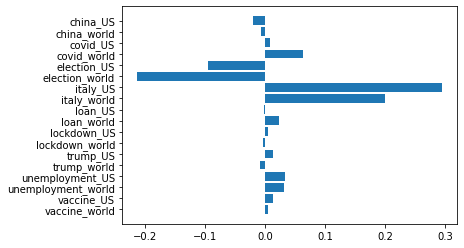

In [47]:
plt.barh(y=df_turnings['Features'], width=df_turnings['Period_1_ratio'])

<BarContainer object of 18 artists>

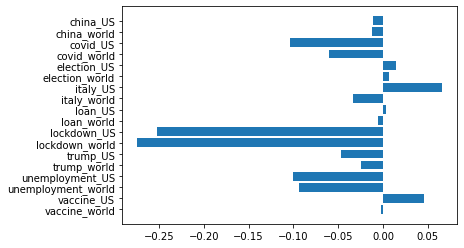

In [48]:
plt.barh(y=df_turnings['Features'], width=df_turnings['Period_2_ratio'])

<BarContainer object of 18 artists>

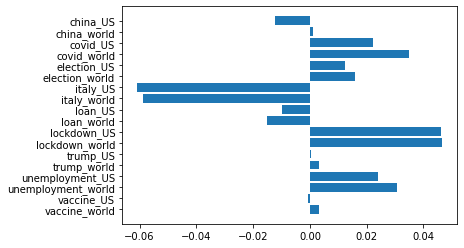

In [49]:
plt.barh(y=df_turnings['Features'], width=df_turnings['Period_3_ratio'])

<BarContainer object of 18 artists>

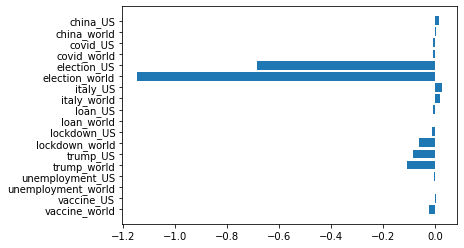

In [50]:
plt.barh(y=df_turnings['Features'], width=df_turnings['Period_4_ratio'])

In [58]:
import seaborn as sns

improvement_cols = ['Period_1_ratio', 'Period_2_ratio', 'Period_3_ratio', 'Period_4_ratio']
df_melt = pd.melt(df_turnings, id_vars=['Features'], value_vars=improvement_cols, var_name='Period', value_name='ratio')
df_melt.head()

,Features,Period,ratio
0,vaccine_world,Period_1_ratio,0.004201
1,vaccine_US,Period_1_ratio,0.013430
2,unemployment_world,Period_1_ratio,0.030993
3,unemployment_US,Period_1_ratio,0.032650
4,trump_world,Period_1_ratio,-0.007932


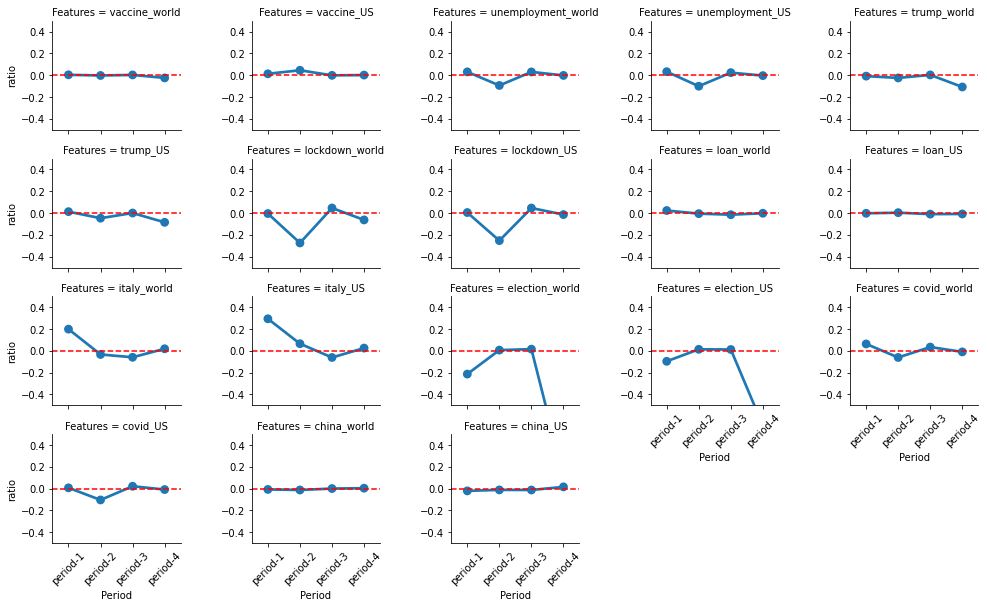

In [52]:
g = sns.catplot(x='Period', y='ratio', col='Features', col_wrap=5, data=df_melt, 
                kind="point", orient="v", height=2,  aspect=1.4, sharey=False)
# g.set(ylim=(df_melt['ratio'].min(), df_melt['ratio'].max()))
g.set(ylim=(-0.5, 0.5))
g.set_xticklabels(['period-1', 'period-2', 'period-3', 'period-4'], rotation=45)
axes = g.fig.axes
for ax in axes:
    ax.axhline(0, color='r', ls='--')

### Select categories

In [53]:
# dataframe for all categories of google trends
df_ct = pd.read_csv(DATA_2020_DIR + 'categories.csv',parse_dates=['date'])
df_ct['date'] = df_ct['date'] + pd.Timedelta('1d')
df_ct.set_index('date',inplace = True)
df_ct = df_ct[:-4]
df_ct.insert(0,'close',df_ns['Close'][1:])
df_ct['close_l1'] = df_ns['Close'][:-1].values
df_ct.head()

,close,Arts & Entertainment,Autos & Vehicles,Beauty & Fitness,Books & Literature,Business & Industrial,Computers & Electronics,Finance,Food & Drink,Games,Health,Hobbies & Leisure,Home & Garden,Internet & Telecom,Jobs & Education,Law & Government,News,Online Communities,People & Society,Pets & Animals,Real Estate,Reference,Science,Shopping,Sports,Travel,Celebrities & Entertainment News,Comics & Animation,Entertainment Industry,Events & Listings,Fun & Trivia,Humor,Movies,Music & Audio,Offbeat,Online Media,Performing Arts,TV & Video,Visual Art & Design,Automotive Industry,...,Stock Photography,Sports Memorabilia,Boxing,Martial Arts,Wrestling,Drag & Street Racing,Stunts & Dangerous Feats,Golf,Gymnastics,Racquet Sports,Skate Sports,Track & Field,American Football,Baseball,Basketball,Cheerleading,Cricket,Handball,Hockey,Rugby,Soccer,Volleyball,Ice Skating,Skiing & Snowboarding,Olympics,Airport Parking & Transportation,Adventure Travel,Agritourism,Ecotourism,Sightseeing Tours,Vineyards & Wine Tourism,Beaches & Islands,Historical Sites & Buildings,Lakes & Rivers,Mountain & Ski Resorts,Regional Parks & Gardens,Theme Parks,Tourist Boards & Visitor Centers,Vacation Offers,close_l1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,9092.190430,100.0,75.307692,92.0,50.0,47.0,63.228916,37.0,76.766667,85.0,45.0,100.0,59.0,62.0,38.557377,39.0,5.901639,94.0,84.0,74.0,73.561224,74.211765,36.515625,68.25,42.0,81.0,39.00,75.454545,14.0,96.0,68.0,82.0,83.870968,97.0,60.0,83.337662,73.0,89.24,45.0,8.0,...,71.0,48.0,2.857143,8.0,36.0,45.0,50.133333,23.448276,46.0,12.000000,44.25,44.0,26.0,14.928571,6.0,38.0,100.0,63.0,82.0,36.0,49,51.0,82.0,88.0,18.0,79.0,83.0,25.0,66.920635,81.0,46.097561,76,48.164706,45.584416,93.0,56.64,55.0,59.0,74.0,9092.190430
2020-01-03,9020.769531,83.0,85.087912,98.0,52.0,60.0,81.012048,59.0,54.716667,82.0,57.0,68.0,61.0,71.0,59.672131,49.0,5.770492,82.0,84.0,73.0,87.183673,79.094118,48.093750,63.00,36.0,82.0,28.60,70.909091,12.0,73.0,70.0,67.0,72.129032,77.0,60.0,75.272727,64.0,76.36,47.0,13.0,...,88.0,49.0,3.047619,8.0,35.0,46.0,44.266667,24.620690,45.0,14.571429,43.50,50.0,21.0,15.714286,6.0,42.0,73.0,54.0,48.0,38.0,37,58.0,63.0,95.0,15.0,94.0,97.0,30.0,77.746032,79.0,35.560976,77,46.541176,47.272727,95.0,53.76,54.0,95.0,82.0,9092.190430
2020-01-04,9037.669596,81.0,83.131868,94.0,49.0,62.0,80.024096,60.0,53.083333,73.0,57.0,63.0,60.0,73.0,56.918033,52.0,6.557377,80.0,82.0,69.0,84.459184,79.094118,47.203125,61.50,32.0,83.0,35.88,66.363636,12.0,78.0,69.0,65.0,67.096774,72.0,59.0,73.480519,64.0,76.36,45.0,13.0,...,77.0,50.0,2.666667,8.0,35.0,50.0,38.400000,26.379310,46.0,15.428571,43.50,47.0,19.0,15.714286,6.0,37.0,29.0,60.0,60.0,41.0,32,55.0,67.0,88.0,16.0,85.0,87.0,42.0,62.984127,76.0,40.829268,74,41.129412,47.272727,100.0,55.68,49.0,90.0,77.0,9020.769531
2020-01-05,9054.569662,86.0,82.153846,98.0,47.0,49.0,69.156627,44.0,61.250000,79.0,47.0,65.0,64.0,64.0,44.065574,43.0,5.901639,76.0,80.0,74.0,79.010204,71.282353,39.187500,61.50,42.0,83.0,37.44,69.090909,13.0,89.0,64.0,71.0,78.000000,74.0,63.0,74.376623,67.0,77.28,42.0,13.0,...,69.0,54.0,2.666667,9.0,50.0,44.0,42.133333,26.965517,47.0,14.571429,48.00,58.0,35.0,14.928571,7.0,46.0,30.0,50.0,61.0,42.0,55,66.0,81.0,91.0,16.0,87.0,86.0,54.0,61.015873,91.0,41.487805,76,41.129412,47.272727,88.0,51.84,47.0,57.0,76.0,9037.669596
2020-01-06,9071.469727,89.0,75.307692,97.0,49.0,47.0,68.168675,35.0,62.883333,82.0,46.0,66.0,66.0,62.0,44.983607,41.0,5.770492,78.0,86.0,73.0,76.285714,70.305882,40.078125,64.50,66.0,80.0,36.92,69.090909,19.0,78.0,65.0,68.0,78.838710,76.0,60.0,75.272727,65.0,81.88,43.0,13.0,...,75.0,59.0,2.666667,8.0,43.0,39.0,41.600000,25.793103,45.0,13.714286,46.50,46.0,97.0,14.928571,6.0,49.0,41.0,45.0,59.0,37.0,48,67.0,72.0,84.0,15.0,83.0,98.0,41.0,73.809524,80.0,34.902439,75,44.376471,43.896104,84.0,52.80,48.0,48.0,74.0,9054.569662


In [54]:
import json
# build a dataframe saving relationship of all categories of google trends
def extract_categories(level=0, return_key='name'):
    cates = []
    with open(DATA_2020_DIR + 'cat.json') as f:
        data = json.load(f)
        if level == 0:
            cates.append(data[return_key])
        if level == 1:
            for i in data['children']:
                cates.append(i[return_key])
        if level == 2:
            for i in data['children']:
                for j in i['children']:
                    cates.append(j[return_key])
        if level == 3:
            for i in data['children']:
                for j in i['children']:
                    if 'children' in j:
                        for k in j['children']:
                            cates.append(k[return_key])
    return cates
df_cat = pd.DataFrame({'name':[], 'id':[], 'level':[]})
for i in [0,1,2,3]:
    df_temp = pd.DataFrame({'name':extract_categories(i,'name'), 'id':extract_categories(i,'id'), 'level':i})
    df_cat = df_cat.append(df_temp)
df_cat['level'] = df_cat['level'].astype(int)
df_cat['id'] = df_cat['id'].astype(int)
df_cat = df_cat.drop_duplicates(subset=['name'], keep='first')
df_cat = df_cat.reset_index(drop='True')
df_cat.head()

,name,id,level
0,All categories,0,0
1,Arts & Entertainment,3,1
2,Autos & Vehicles,47,1
3,Beauty & Fitness,44,1
4,Books & Literature,22,1


In [ ]:
# build first level trainging data
X_ct1 = df_ct[df_cat[df_cat['level'] == 1]['name'].values] 
X_ct1['close_l1'] = df_ct['close_l1']
y_ct = df_ct['close']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Spike and slab model setup: $y_t = a_0b_0y_{t-1}$ + $\sum_{i=1}^n a_ib_itrends_i$ + $\alpha$, where y_t is the close price on day t, $trends_i$ is ith query of google trends on day $t-1$, $a_i$ has a prior Bernoulli distribution with mean $x_i$, $b_i$ has prior Normal distribution with mean 1 and steddv 5. We assume $p(y_t|a_i,b_i,\alpha)\sim N(y_{observed},noise)$ where $noise\sim Gamma(2,1)$. Through MCMC algorithm, we compute posterior marginal distribution $p(a_i|data),p(\alpha|data)$ and $p(b_i|data)$.

In [ ]:
def get_model(y, X):
    model = pm.Model()
    with model:
        xi = pm.Bernoulli('xi', .1, shape=X.shape[1]) #prior inclusion probability for each variable
        alpha = pm.Normal('alpha', mu = 0, sd = 500) # prior Intercept distribution
        beta = pm.Normal('beta', mu = 1, sd = 5 , shape=X.shape[1]) #Prior for the non-zero coefficients
        p = pm.math.dot(X, xi * beta) #Deterministic function to map the stochastics to the output
        noise = pm.Gamma('noise', alpha=2, beta=1) #noise
        y_obs = pm.Normal('y_obs', mu = p, sd = noise ,observed = y)  #Data likelihood
    return model

In [ ]:
model_spike = get_model(y_ct, X_ct1)
# sampling
with model_spike:
    trace = pm.sample(5000, random_seed = 4816, cores = 1, progressbar = True, chains = 2)

In [169]:
results_spike = pd.DataFrame({'var': X_ct1.columns, 
                        'inclusion_probability':np.apply_along_axis(np.mean, 0, trace['xi']),
                       'beta':np.apply_along_axis(np.mean, 0, trace['beta']),
                       'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace['xi']*trace['beta'])
                            /np.apply_along_axis(np.sum, 0, trace['xi'])
                       })
# save results for the first level
spike_level0 = results_spike.sort_values('inclusion_probability', ascending = False)
spike_level0 = spike_level0[spike_level0['inclusion_probability']>0.01] #default accept probability
spike_level0

,var,inclusion_probability,beta,beta_given_inclusion
25,close_l1,1.0000,0.998561,0.998561
15,News,0.6174,0.953432,1.140536
20,Reference,0.5000,-0.885383,-2.770766
12,Internet & Telecom,0.5000,2.385304,3.770608
18,Pets & Animals,0.0185,0.853469,-0.169355
9,Health,0.0125,1.240406,-0.237030


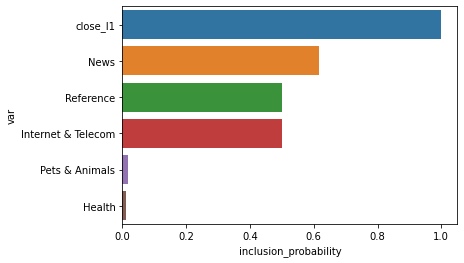

In [170]:
import seaborn as sns
sns.barplot(y = 'var',x = 'inclusion_probability',data = spike_level0)

In [ ]:
pm.plot_posterior(trace)

In [172]:
parent = pd.read_csv(DATA_2020_DIR + 'categories_id_level_parent.csv')
# df_ct_2 contain all the sub topics of the topics selected above
df_ct_2 = parent[parent['parent_id'].isin(parent[parent['name'].isin(spike_level0['var'])]['id'])]

In [ ]:
X_ct2 = df_ct[df_ct_2['name'].values]
X_ct2['close_l1'] = df_ct['close_l1']
model_spike_2 = get_model(y_ct, X_ct2)
with model_spike_2:
    trace2 = pm.sample(5000, random_seed = 4816, cores = 1, progressbar = True, chains = 2)

In [174]:
results_spike_2 = pd.DataFrame({'var': X_ct2.columns, 
                        'inclusion_probability':np.apply_along_axis(np.mean, 0, trace2['xi']),
                       'beta':np.apply_along_axis(np.mean, 0, trace2['beta']),
                       'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace2['xi']*trace2['beta'])
                            /np.apply_along_axis(np.sum, 0, trace2['xi'])
                       })
spike_level1 = results_spike_2.sort_values('inclusion_probability', ascending = False)
spike_level1 = spike_level1[spike_level1['inclusion_probability']>0.05] #default accept probability
spike_level1

,var,inclusion_probability,beta,beta_given_inclusion
49,close_l1,1.0000,1.000298,1.000298
30,Broadcast & Network News,0.8165,1.777214,2.064110
0,Aging & Geriatrics,0.5000,-1.252772,-3.505543
11,Nursing,0.1200,1.253237,2.641407
15,Pharmacy,0.1046,0.921307,2.198345
34,Newspapers,0.0776,0.990786,2.284369
7,Medical Facilities & Services,0.0720,0.778409,1.406490
35,Politics,0.0571,0.801258,-2.084113
42,Directories & Listings,0.0536,1.103734,1.873192


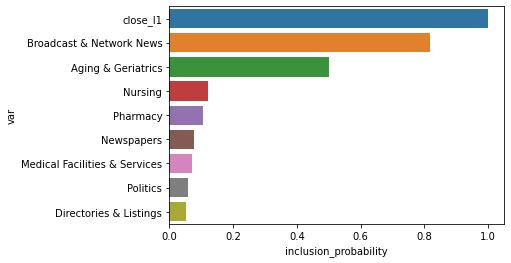

In [175]:
sns.barplot(y = 'var', x = 'inclusion_probability', data = spike_level1)

In [ ]:
df_ct_3 = parent[parent['parent_id'].isin(parent[parent['name'].isin(spike_level1['var'])]['id'])]
X_ct3 = df_ct[df_ct_3['name'].values]
X_ct3['close_l1'] = df_ct['close_l1']
model_spike_3 = get_model(y_ct, X_ct3)
with model_spike_3:
    trace3 = pm.sample(5000, random_seed = 4816, cores = 1, progressbar = True, chains = 2)

In [177]:
results_spike_3 = pd.DataFrame({'var': X_ct3.columns, 
                        'inclusion_probability':np.apply_along_axis(np.mean, 0, trace3['xi']),
                       'beta':np.apply_along_axis(np.mean, 0, trace3['beta']),
                       'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace3['xi']*trace3['beta'])
                            /np.apply_along_axis(np.sum, 0, trace3['xi'])
                       })
spike_level2 = results_spike_3.sort_values('inclusion_probability', ascending = False)
spike_level2 = spike_level2[spike_level2['inclusion_probability']>0.01] #default accept probability
spike_level2

,var,inclusion_probability,beta,beta_given_inclusion
14,close_l1,1.0000,1.000255,1.000255
11,Political Polls & Surveys,0.6902,1.188949,1.470422
7,Campaigns & Elections,0.5385,1.101872,0.935614
12,Right-Wing Politics,0.0158,1.026692,0.449111
8,Left-Wing Politics,0.0136,0.969531,0.737818
0,Alzheimer's Disease,0.0109,0.886187,-0.304198


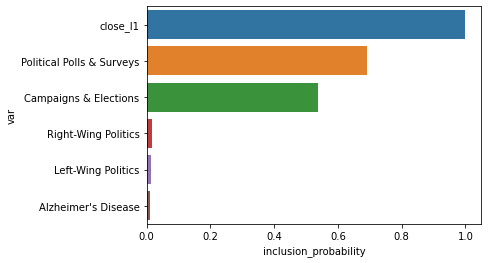

In [178]:
sns.barplot(y = 'var', x = 'inclusion_probability',data = spike_level2)